## Creating Custom Networks
In this notebook you have to create a custom network whose architecture has been given, and use the dataset you created earlier to train and test it.

TODO:
Change root dir and CIFAR dir



In [1]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
import os
import torchvision
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

All hyper parameters go in the next block

In [2]:
batch_size = 100
num_epochs = 5
learning_rate = 0.01

### Create Custom Dataset and Loader
This is the same as part 1. Simply use the same code to create the dataset.

In [3]:
class CDATA(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.        
        
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        if train == True:
            dir1 = '/train/'
        else:
            dir1 = '/test/'
        
        dir_names = os.listdir(root_dir + dir1)
        img_names=[]
        labels = []
        count = 0
        for c in dir_names[0:10]:
            names = os.listdir(root_dir + dir1 + c)
            N = len(names)
            for n in range(N):
                img_names.append(str(root_dir + dir1 + c + '/' + names[n]))
                labels += [count]
            count+=1
               
        
        self.img_names = img_names
        self.labels = labels        
        
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        
        return len(self.img_names)
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        #temp = mpimg.imread(self.img_names[idx])
        
        img_pil = Image.open(self.img_names[idx]).convert('RGB')
        return self.transform(img_pil), self.labels[idx]

In [4]:
composed_transform = transforms.Compose([transforms.Scale((32,32)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='./data/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='./data/', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Creating a Custom Network
It's time to create a new custom network. This network is based on Resnet (indeed it is a resnet since it uses skip connections). The architecture of the network is provided in the diagram. It specifies the layer names, layer types as well as their parameters.
<img src="architecture.png" width=100>
[Full size image](architecture.html)

In [5]:
class CustomResnet(nn.Module): # Extend PyTorch's Module class
    def __init__(self, num_classes = 10):
        super(CustomResnet, self).__init__() # Must call super __init__()
        
        # Define the layers of the network here
        # There should be 17 total layers as evident from the diagram
        # The parameters and names for the layers are provided in the diagram
        # The variable names have to be the same as the ones in the diagram
        # Otherwise, the weights will not load
        
        self.conv1 = torch.nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(64)
        self.relu =torch.nn.ReLU(True)
        self.maxpool= torch.nn.MaxPool2d(3, stride=2, padding=1)
        
        self.lyr1conv1 = torch.nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=True)
        self.lyr1bn1 = torch.nn.BatchNorm1d(64)
        self.lyr1relu1 =torch.nn.ReLU(inplace=True)
        
        self.lyr1conv2 = torch.nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=True)
        self.lyr1bn2 = torch.nn.BatchNorm1d(64)
        self.lyr1relu2 =torch.nn.ReLU(inplace=True)
        
        self.lyr2conv1 = torch.nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=True)
        self.lyr2bn1 = torch.nn.BatchNorm1d(64)
        self.lyr2relu1 =torch.nn.ReLU(inplace=True)
        
        self.lyr2conv2 = torch.nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=True)
        self.lyr2bn2 = torch.nn.BatchNorm1d(64)
        self.lyr2relu2 =torch.nn.ReLU(inplace=True)
        
        self.fc = torch.nn.Linear(4096, num_classes)
        
       
        
    def forward(self, x):
        # Here you have to define the forward pass
        # Make sure you take care of the skip connections
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x1 = self.maxpool(x)

        x = self.lyr1conv1(x1)
        x = self.lyr1bn1(x)
        x = self.lyr1relu1(x)
        
        x = self.lyr1conv2(x)
        x = self.lyr1bn2(x)
        x1 = self.lyr1relu2(x+x1)
        
        x = self.lyr2conv1(x1)
        x = self.lyr2bn1(x)
        x = self.lyr2relu1(x)
        
        x = self.lyr2conv2(x)
        x = self.lyr2bn2(x)
        x = self.lyr2relu2(x+x1)
        
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x
        

#### Finetune on pre-trained CIFAR-100 weights
We shall now finetune our model using pretrained CIFAR-100 weights.

In [6]:
model = CustomResnet(num_classes = 100) # 100 classes since CIFAR-100 has 100 classes

# Load CIFAR-100 weights. (Download them from assignment page)
# If network was properly implemented, weights should load without any problems
model.load_state_dict(torch.load('./CIFAR-100_weights')) # Supply the path to the weight file

##### Optional
As a sanity check you may load the CIFAR-100 test dataset and test the above model. You should get an accuracy of ~41%. This part is optional and is meant for your convenience.

In [7]:
# Block for optionally running the model on CIFAR-100 test set
# composed_transform = transforms.Compose([transforms.Scale((32,32)),transforms.ToTensor()])
# train_dataset = CDATA(root_dir='../a1/', train=True, transform=composed_transform) # Supply proper root_dir
# test_dataset = CDATA(root_dir='../a1/', train=False, transform=composed_transform) # Supply proper root_dir

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Let's finetune the model.

torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size

torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size

torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size([100, 10])
torch.Size

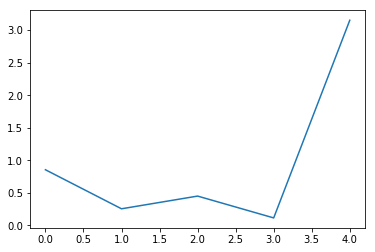

CPU times: user 33.8 s, sys: 3.02 s, total: 36.8 s
Wall time: 37 s


In [8]:
for param in model.parameters():
    param.requires_grad = False

# Change last layer to output 10 classes since our dataset has 10 classes
model.fc = nn.Linear(model.fc.in_features,10)# Complete this statement. It is similar to the resnet18 case
model.cuda()

# Loss function and optimizers
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.fc.parameters(), lr = learning_rate) 


def train():
    # Code for training the model
    # Make sure to output a matplotlib graph of training losses
    
    loss_epoch = np.array([])
    for epoch in range(num_epochs):        
        
        model.train()        
        for i, (input1,target) in enumerate(train_loader):
            
            input_var = torch.autograd.Variable(input1).cuda()            
            target = target.cuda(async = True)
            target_var = torch.autograd.Variable(target)
            
            output = model(input_var)            
            loss = criterion(output, target_var)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            output = output.float()
            loss = loss.float()
            
        loss_epoch = np.concatenate((loss_epoch,loss.cpu().data.numpy()))
    
    plt.plot(loss_epoch)
    plt.show()
    
%time train()

Test the finetuned model

In [9]:
def test():
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for i, (input1,target) in enumerate(test_loader):
            
            input_var = torch.autograd.Variable(input1,volatile = True).cuda()
            
            target = target.cuda(async = True)
            target_var = torch.autograd.Variable(target)
                        
            output = model(input_var)
            output = output.float()
            
            t1 = output.max(1)[1].cpu().data.numpy()
            t2 = target_var.cpu().data.numpy()
            correct += sum(t1==t2)
            total += len(t2)
            
    print('Accuracy: '+ str(correct*100.0/total))
%time test()

Accuracy: 89.1443850267
CPU times: user 1.23 s, sys: 136 ms, total: 1.37 s
Wall time: 1.39 s


#### Training from scratch
Now we shall try training the model from scratch and observe the differences.

In [ ]:
# Reinstantiate the model and optimizer
model = CustomResnet(num_classes = 10)
model.cuda()

for param in model.parameters():
    param.requires_grad = True
    
optimizer_fromScratch = torch.optim.Adam(model.parameters(), lr = learning_rate) 
criterion = nn.CrossEntropyLoss().cuda()

# Train
%time train()

# Test
%time test()

This is the end of Assignment 1